In [1]:
! pip install kaggle
! mkdir ~/.kaggle #creating a hidden directory
! cp kaggle.json ~/.kaggle/ #pasting the kaggle api token to above dir
! chmod 600 ~/.kaggle/kaggle.json ## chaging the mode for the file

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


**Put the name of the dataset **

In [2]:
! kaggle datasets download deadskull7/fer2013 # downloading the datset

Dataset URL: https://www.kaggle.com/datasets/deadskull7/fer2013
License(s): CC0-1.0
 84% 81.0M/96.6M [00:00<00:00, 102MB/s]
100% 96.6M/96.6M [00:00<00:00, 110MB/s]


In [3]:
! unzip /content/fer2013.zip #unzip the downloaded dataset

Archive:  /content/fer2013.zip
  inflating: fer2013.csv             


#Importing necesaary files
<hr>



In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D,MaxPool2D,ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import vgg16
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

#for model deployement
import os
import cv2
import numpy as np
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import img_to_array

In [5]:
df = pd.read_csv('./fer2013.csv') #read dataset

df.head(5),df.shape  #first five rows and count of rows and columns

(   emotion                                             pixels     Usage
 0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
 1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
 2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
 3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
 4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training,
 (35887, 3))

#Exploraotry Data Analysis
<hr>



In [6]:
print("Null values present in the file:",df.isna().sum().sum())
print("Basic information about the dataframe:")
df.info()

df.describe()

Null values present in the file: 0
Basic information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [7]:
emotions = { #list of available emotions in the dataset
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Sad",
    5:"Surprize",
    6:"Neutral"
}

##No of images present in dataset corresponding to each emotion

In [8]:
count_emotions = (df.groupby(df['emotion'])['pixels'].count()).to_frame()
count_emotions['emotion name'] = [emotions[k] for k in emotions.keys()]
count_emotions

,pixels,emotion name
emotion,,
0,4953,Angry
1,547,Disgust
2,5121,Fear
3,8989,Happy
4,6077,Sad
5,4002,Surprize
6,6198,Neutral


##No of images present in dataset corresponding to training testing and validation part

In [9]:
count_usage = (df.groupby(df['Usage'])['pixels'].count()).to_frame()
count_usage

,pixels
Usage,
PrivateTest,3589
PublicTest,3589
Training,28709


##Visualizing images from the dataset

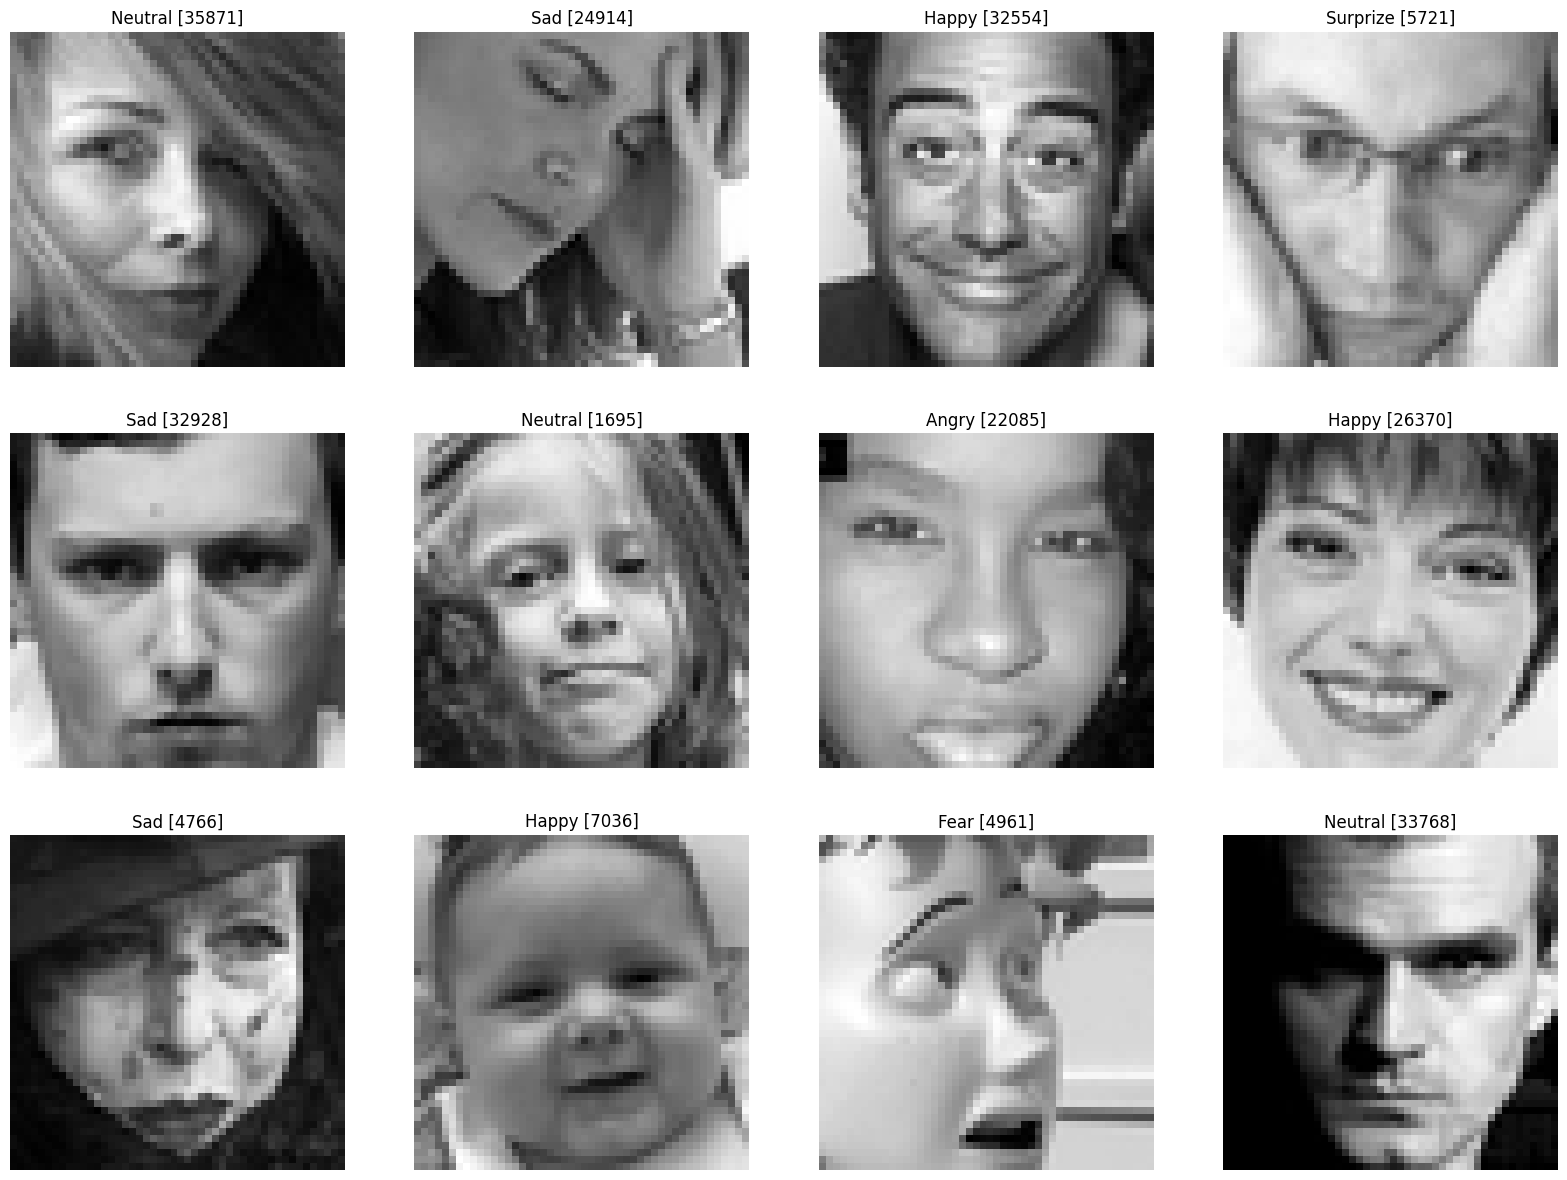

In [10]:
# from PIL import Image
# pixels = df['pixels'][0]
# b = bytes(int(p) for p in pixels.split())
# i = Image.frombuffer('L',(48,48),b)
# di.save('a.png')
def visualize_images(n_img=4):
    indices = np.random.randint(0,df.shape[0],size=n_img)
#     print(indices)
    plt.figure(figsize=(20,20))
    for i,l in zip(indices,range(0,len(indices))):
        image_ar = np.array([i for i in  df['pixels'][i].split()] , dtype='float')
        pixels = np.reshape(image_ar,(48,48))
        ax = plt.subplot(4,4,l+1)
        plt.imshow(pixels,cmap='gray')
        plt.title(emotions[df['emotion'][i]]+" ["+str(i)+"]")
        plt.xticks()
        plt.yticks([])
        plt.axis("off")
visualize_images(12)

#Data Preprocessing
<hr>

## Extracting rows for each part

In [11]:
X_train,y_train = [],[]
X_val,y_val = [],[]
X_test,y_test = [],[]
for index,row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PrivateTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_val.append(np.array(k))
        y_val.append(row['emotion'])

X_train = np.array(X_train,dtype='float')
y_train = np.array(y_train)
X_test = np.array(X_test,dtype='float')
y_test = np.array(y_test)
X_val = np.array(X_val,dtype='float')
y_val = np.array(y_val)

In [12]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

((28709, 2304), (28709,), (3589, 2304), (3589,), (3589, 2304), (3589,))

**we have to change the shape of the images to train them as the above shape is not compatible**

In [13]:
X_train = X_train.reshape(X_train.shape[0],48,48,1)
X_test = X_test.reshape(X_test.shape[0],48,48,1)
X_val = X_val.reshape(X_val.shape[0],48,48,1)

y_train = to_categorical(y_train,num_classes=7)
y_test = to_categorical(y_test,num_classes=7)
y_val = to_categorical(y_val,num_classes=7)

X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

((28709, 48, 48, 1),
 (28709, 7),
 (3589, 48, 48, 1),
 (3589, 7),
 (3589, 48, 48, 1),
 (3589, 7))

#Defining Model Archietechture

VGG16

In [14]:
def cnn_model():
  model = Sequential()

  model.add(ZeroPadding2D((1,1),input_shape=(48,48,1),name="block1_pad1"))
  model.add(Conv2D(64, (3, 3), activation='relu',name="block1_l1"))
  model.add(ZeroPadding2D((1,1),name="block1_pad2"))
  model.add(Conv2D(64, (3, 3), activation='relu',name="block1_l2"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool1"))

  model.add(ZeroPadding2D((1,1),name="block2_pad1"))
  model.add(Conv2D(128, (3, 3), activation='relu',name="block2_l1"))
  model.add(ZeroPadding2D((1,1),name="block2_l2"))
  model.add(Conv2D(128, (3, 3), activation='relu',name="block2_pad2"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool2"))

  model.add(ZeroPadding2D((1,1),name="block3_pad1"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l1"))
  model.add(ZeroPadding2D((1,1),name="block3_pad2"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l2"))
  model.add(ZeroPadding2D((1,1),name="block3_pad3"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool3"))

  model.add(ZeroPadding2D((1,1),name="block4_pad1"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l1"))
  model.add(ZeroPadding2D((1,1),name="block4_pad2"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l2"))
  model.add(ZeroPadding2D((1,1),name="block4_pad3"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool4"))


  model.add(ZeroPadding2D((1,1),name="block5_pad1"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l1"))
  model.add(ZeroPadding2D((1,1),name="block5_pad2"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l2"))
  model.add(ZeroPadding2D((1,1), name="block5_pad3"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool5"))

  model.add(Flatten())
  model.add(Dense(4096, activation='relu',name="block6"))
  model.add(Dropout(0.5,name="drop1"))
  model.add(Dense(4096, activation='relu',name="block7"))
  model.add(Dropout(0.5,name="drop2"))
  model.add(Dense(7, activation='softmax',name="block8"))

  return model

In [15]:
model = cnn_model()
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_pad1 (ZeroPadding2D)          │ (None, 50, 50, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_l1 (Conv2D)                   │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pad2 (ZeroPadding2D)          │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_l2 (Conv2D)                   │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pad1 (ZeroPadding2D)          │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_l1 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_l2 (ZeroPadding2D)            │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pad2 (Conv2D)                 │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pad1 (ZeroPadding2D)          │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_l1 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pad2 (ZeroPadding2D)          │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_l2 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pad3 (ZeroPadding2D)          │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_l3 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pad1 (ZeroPadding2D)          │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_l1 (Conv2D)                   │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pad2 (ZeroPadding2D)          │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_l2 (Conv2D)                   │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 33,624,775 (128.27 MB)

 Trainable params: 33,624,775 (128.27 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
checkpointer = [
    EarlyStopping(monitor='val_accuracy', verbose=1, restore_best_weights=True, mode="max", patience=10),
    ModelCheckpoint('best_model.keras', monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")
]

history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=30,
    callbacks=checkpointer,
    validation_data=(X_val, y_val)
)

# Save the model in .h


Epoch 1/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2429 - loss: 1.8370
Epoch 1: val_accuracy improved from -inf to 0.24937, saving model to best_model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 56s 53ms/step - accuracy: 0.2429 - loss: 1.8369 - val_accuracy: 0.2494 - val_loss: 1.8086
Epoch 2/30
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2620 - loss: 1.7862
Epoch 2: val_accuracy improved from 0.24937 to 0.26832, saving model to best_model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 66s 43ms/step - accuracy: 0.2620 - loss: 1.7862 - val_accuracy: 0.2683 - val_loss: 1.7650
Epoch 3/30
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3530 - loss: 1.6493
Epoch 3: val_accuracy did not improve from 0.26832
898/898 ━━━━━━━━━━━━━━━━━━━━ 39s 43ms/step - accuracy: 0.3530 - loss: 1.6492 - val_accuracy: 0.2148 - val_loss: 1.8613
Epoch 4/30
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4113 - loss: 1.5137
Epoch 4: val_accuracy improved from 0.26832 to 0.36668, saving model 

#Model Evaluation


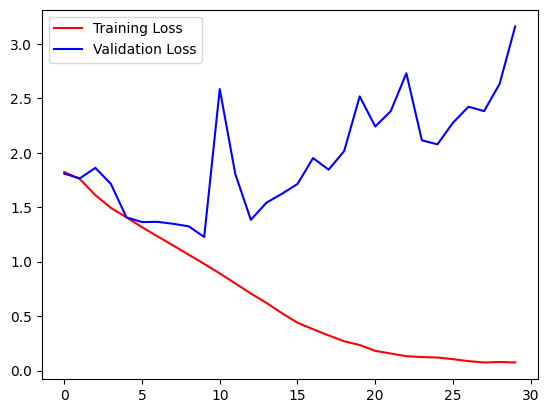

In [18]:
def loss_plot(history):
  plt.plot(history.history["loss"],'r', label="Training Loss")
  plt.plot(history.history["val_loss"],'b', label="Validation Loss")
  plt.legend()

loss_plot(history)

In [19]:
# Model Inference
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


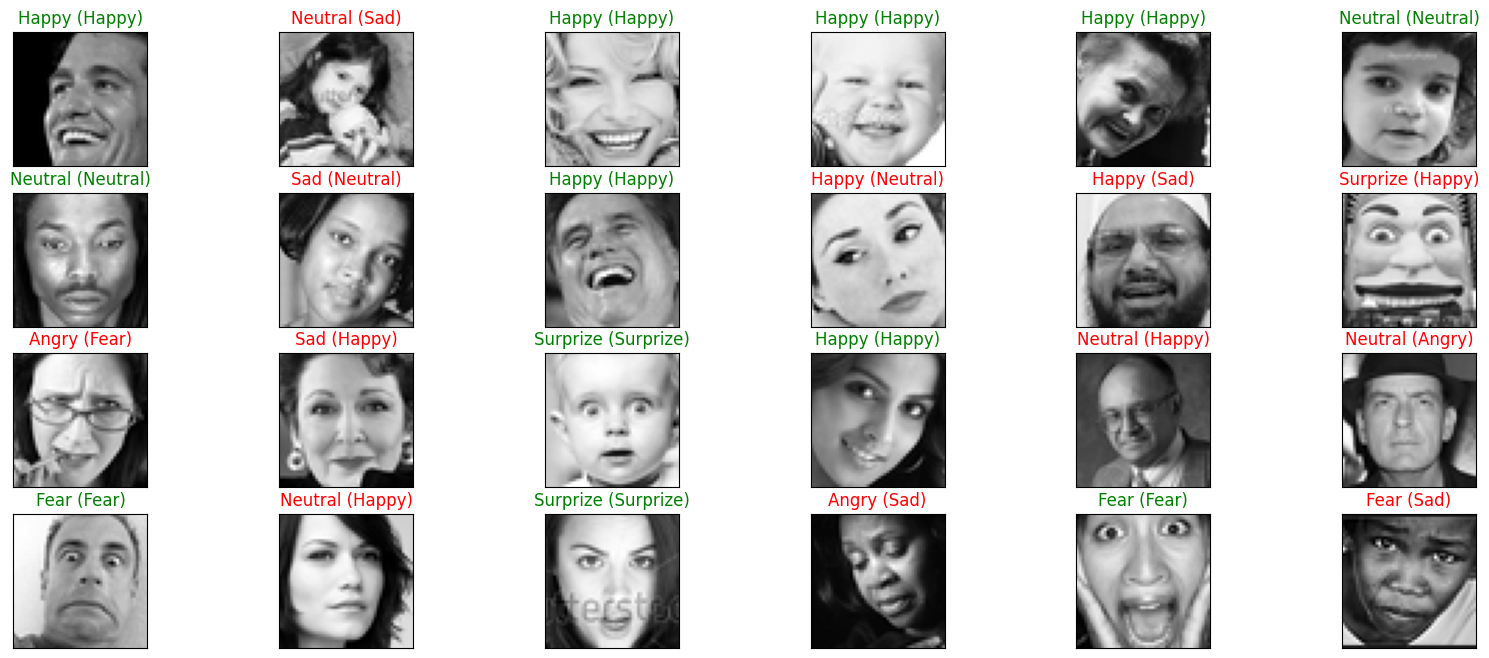

In [20]:
#function to plot images with their lables(actual vs predicted)
def check_images(X_test,y_pred,label_dict={}):

  figure = plt.figure(figsize=(20, 8))
  for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
      ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(X_test[index]),cmap="gray")
      predict_index = label_dict[(y_pred[index])]
      true_index = label_dict[np.argmax(y_test,axis=1)[index]]

      ax.set_title("{} ({})".format((predict_index),
                                    (true_index)),
                                    color=("green" if predict_index == true_index else "red"))
check_images(X_test,y_pred,emotions)

In [21]:
# function to plot confusion matrix
def conf_mat(y_test,y_pred,labels=['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]):
  CLASS_LABELS  = labels
  cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
  cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'
  plt.figure(figsize = (20,10))
  plt.title('Confusion Matrix', fontsize = 20)
  sns.set(font_scale=1.2)
  ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

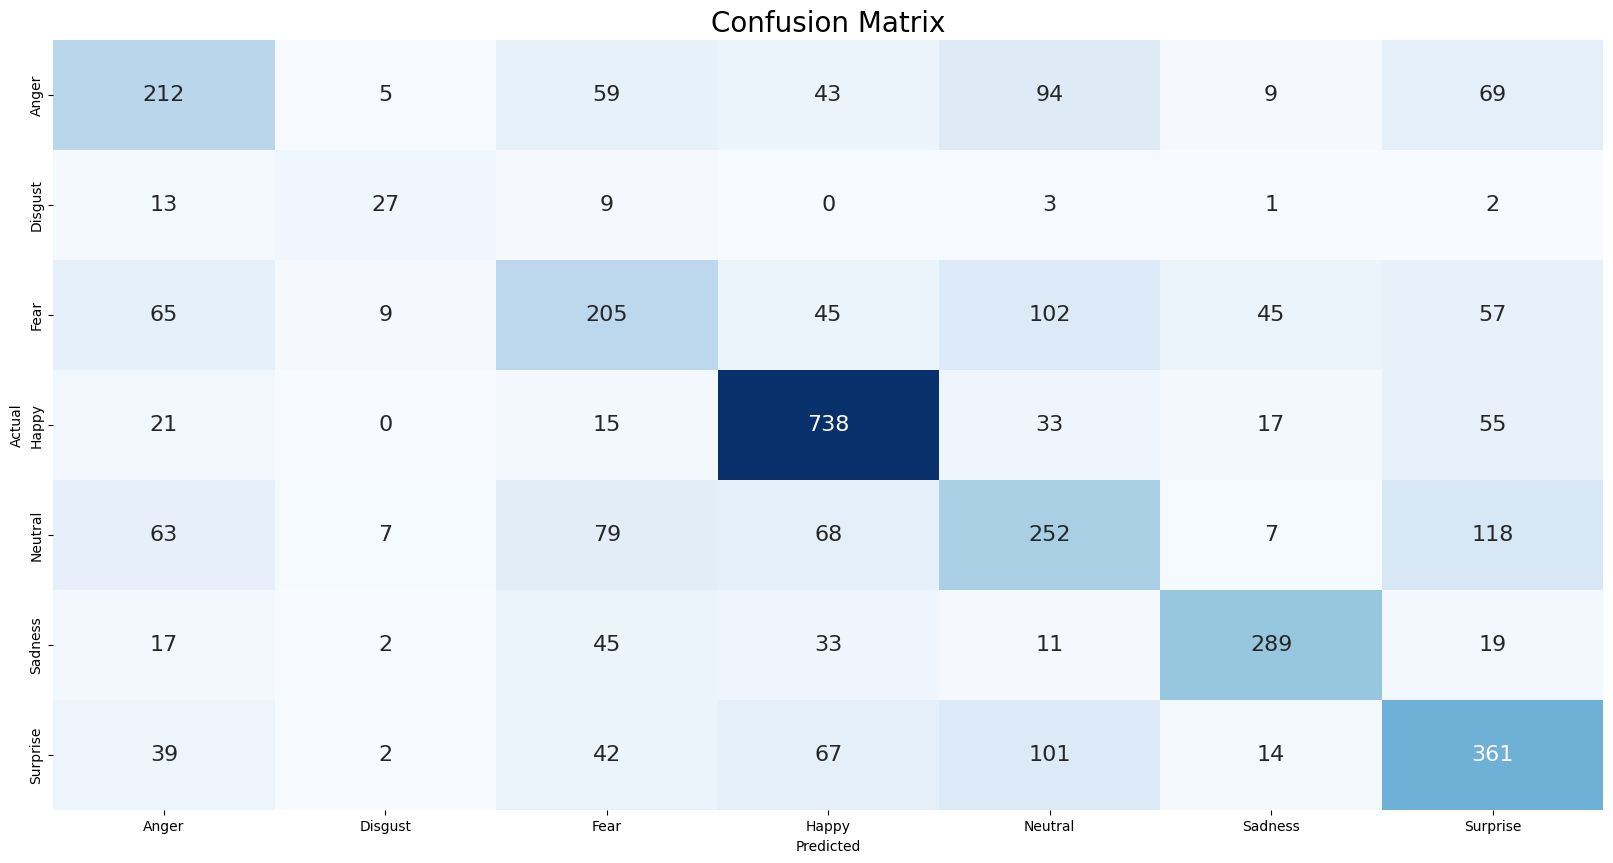

In [22]:
conf_mat(y_test,y_pred)

In [23]:
#classification report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.493     0.432     0.460       491
           1      0.519     0.491     0.505        55
           2      0.452     0.388     0.418       528
           3      0.742     0.840     0.788       879
           4      0.423     0.424     0.424       594
           5      0.757     0.695     0.724       416
           6      0.530     0.577     0.552       626

    accuracy                          0.581      3589
   macro avg      0.559     0.549     0.553      3589
weighted avg      0.574     0.581     0.576      3589



In [24]:
 # loss and accuracy
loss_and_metrics = model.evaluate(X_train,y_train)
print("On Training Data",loss_and_metrics)

loss_and_metrics = model.evaluate(X_val,y_val)
print("On Validation Data",loss_and_metrics)

loss_and_metrics = model.evaluate(X_test,y_test)
print("On Test Data",loss_and_metrics)


898/898 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9764 - loss: 0.0757
On Training Data [0.07445405423641205, 0.9778118133544922]
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5844 - loss: 2.1224
On Validation Data [2.077353000640869, 0.5918083190917969]
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5786 - loss: 2.0389
On Test Data [2.0267574787139893, 0.5806631445884705]


#Fine Tuning


##1. Changing epoch, learning rate and batch size

In [25]:
model = cnn_model()
model.compile(optimizer=SGD(learning_rate=0.005),loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=60,
    callbacks=checkpointer,
    validation_data=(X_val,y_val)
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.2352 - loss: 1.8501
Epoch 1: val_accuracy did not improve from 0.59181
449/449 ━━━━━━━━━━━━━━━━━━━━ 53s 98ms/step - accuracy: 0.2352 - loss: 1.8501 - val_accuracy: 0.2494 - val_loss: 1.8141
Epoch 2/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.2490 - loss: 1.8183
Epoch 2: val_accuracy did not improve from 0.59181
449/449 ━━━━━━━━━━━━━━━━━━━━ 62s 71ms/step - accuracy: 0.2490 - loss: 1.8183 - val_accuracy: 0.2494 - val_loss: 1.7947
Epoch 3/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.2579 - loss: 1.7914
Epoch 3: val_accuracy did not improve from 0.59181
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - accuracy: 0.2580 - loss: 1.7913 - val_accuracy: 0.3530 - val_loss: 1.7164
Epoch 4/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3267 - loss: 1.7026
Epoch 4: val_accuracy did not improve from 0.59181
449/449 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.3267 - loss: 1.7026 - val_accuracy

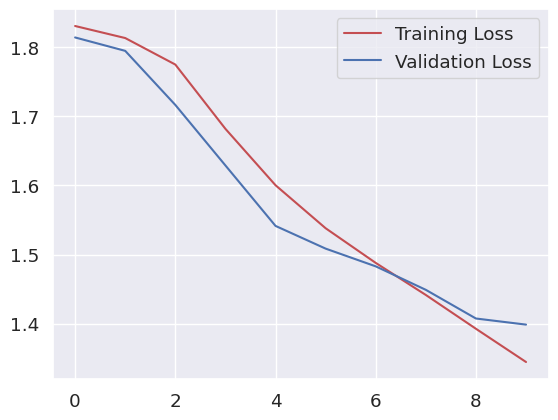

In [26]:
loss_plot(history)

In [27]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       491
           1      0.000     0.000     0.000        55
           2      0.000     0.000     0.000       528
           3      0.245     1.000     0.393       879
           4      0.000     0.000     0.000       594
           5      0.000     0.000     0.000       416
           6      0.000     0.000     0.000       626

    accuracy                          0.245      3589
   macro avg      0.035     0.143     0.056      3589
weighted avg      0.060     0.245     0.096      3589



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##2. Changing optimizer

In [29]:
# loss and accuracy

model = cnn_model()
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=40,
    callbacks=checkpointer,
    validation_data=(X_val,y_val)
)


Epoch 1/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.2507 - loss: 1.8064
Epoch 1: val_accuracy did not improve from 0.59181
449/449 ━━━━━━━━━━━━━━━━━━━━ 49s 93ms/step - accuracy: 0.2508 - loss: 1.8062 - val_accuracy: 0.3792 - val_loss: 1.5528
Epoch 2/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4093 - loss: 1.5022
Epoch 2: val_accuracy did not improve from 0.59181
449/449 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.4093 - loss: 1.5021 - val_accuracy: 0.4617 - val_loss: 1.3739
Epoch 3/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4834 - loss: 1.3304
Epoch 3: val_accuracy did not improve from 0.59181
449/449 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - accuracy: 0.4834 - loss: 1.3304 - val_accuracy: 0.4974 - val_loss: 1.2877
Epoch 4/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5444 - loss: 1.1881
Epoch 4: val_accuracy did not improve from 0.59181
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.5444 - loss: 1.1881 - val_accuracy

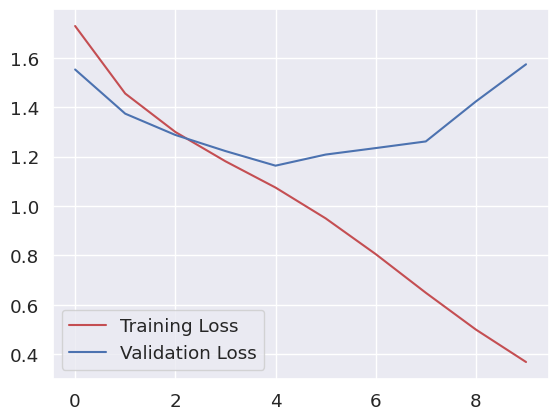

In [30]:
loss_plot(history)

In [31]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       491
           1      0.000     0.000     0.000        55
           2      0.000     0.000     0.000       528
           3      0.245     1.000     0.393       879
           4      0.000     0.000     0.000       594
           5      0.000     0.000     0.000       416
           6      0.000     0.000     0.000       626

    accuracy                          0.245      3589
   macro avg      0.035     0.143     0.056      3589
weighted avg      0.060     0.245     0.096      3589



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#Model Saving

In [32]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
# model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


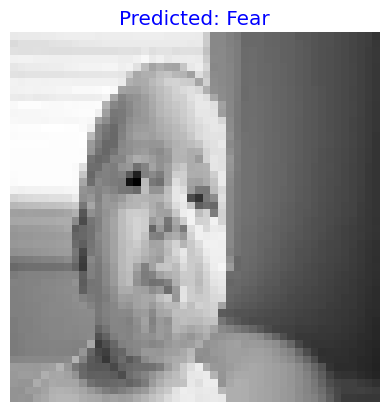

The model predicts: Fear


In [38]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Function to predict a single test image
def predict_image(img_path, model, label_dict):
    """
    Predicts the label for a single image and displays the image with its predicted label.

    Parameters:
    img_path (str): Path to the test image.
    model (keras.Model): Trained model for prediction.
    label_dict (dict): Dictionary mapping label indices to class names.

    Returns:
    None
    """
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(48, 48), color_mode="grayscale")
    img_array = image.img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match model input shape

    # Predict the label
    prediction = model.predict(img_array)
    predicted_label_index = np.argmax(prediction)
    predicted_label = label_dict[predicted_label_index]

    # Display the image with its predicted label
    plt.imshow(img_array[0].squeeze(), cmap="gray")
    plt.title(f"Predicted: {predicted_label}", color="blue")
    plt.axis("off")
    plt.show()

    return predicted_label

# Example usage
img_path = "/content/download.jpg"  # Replace with the actual path to your test image
predicted_label = predict_image(img_path, model, emotions)  # Replace 'emotions' with your label dictionary
print(f"The model predicts: {predicted_label}")

